Get the dataset images

In [2]:
!git clone https://github.com/LeoEmmanuelJoint/FAA_project.git

Cloning into 'FAA_project'...
remote: Enumerating objects: 34659, done.
remote: Counting objects: 100% (10263/10263), done.
remote: Compressing objects: 100% (10251/10251), done.
remote: Total 34659 (delta 16), reused 10251 (delta 10), pack-reused 24396
Receiving objects: 100% (34659/34659), 137.75 MiB | 18.61 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Updating files: 100% (35945/35945), done.


In [3]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# Chemin vers les données d'entraînement et de test
train_data_path = "/kaggle/working/FAA_project/data"#"/content/FAA_project/data"#
test_data_path = "/kaggle/working/FAA_project/new styve/test"#"/content/FAA_project/new styve/test"#

list_emotions = ["anger", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"]
k_folds_val = 5
batch_size_val = 64
epoch_val = 100
number_of_labels = len(list_emotions)

## Setting the train and test dataset

Creating the dataset

In [5]:
def preprocess_data(path_data, classes, img_width=48, img_height=48):
    X_ = []
    y_ = []

    for category in classes:
        path_data_folder = os.path.join(path_data, category)
        class_num = classes.index(category)
        for img in os.listdir(path_data_folder):
            try:
                img_array = cv2.imread(os.path.join(path_data_folder, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                X_.append(img_array)
                y_.append(class_num)
            except Exception as e:
                pass

    X_ = np.array(X_, 'float32')
    y_ = np.array(y_, 'float32')

    #normalizing data between 0 and 1
    X_ -= np.mean(X_, axis=0)
    X_ /= np.std(X_, axis=0)

    X_ = X_.reshape(X_.shape[0], img_width, img_height, 1)

    print("Data shape: ", X_.shape, y_.shape)
    return(X_, y_)

In [6]:
X_train, y_train = preprocess_data(train_data_path, list_emotions)
X_test, y_test = preprocess_data(test_data_path, list_emotions)

input_shape = X_train.shape[1:]

Data shape:  (25409, 48, 48, 1) (25409,)
Data shape:  (10521, 48, 48, 1) (10521,)


Create the model

Building the model based on the architecture :
https://www.nature.com/articles/s41598-022-11173-0

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D

def create_model(BN=False, show=False):
    model=Sequential()

    # Feature extraction layers
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
    if BN: model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    if BN: model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    if BN: model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

    # Classification layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(number_of_labels, activation='softmax'))

    if show: print(model.summary())
    return(model)

Using https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class

In [8]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.metrics import AUC

def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy'])
# #categorical_crossentropy shoyld have been used, yet it does not work

In [9]:
FERmodel = create_model()
compile_model(FERmodel)

In [10]:
FERmodel_BN = create_model(BN=True)
compile_model(FERmodel_BN)

Train the model on k folds

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def train_kfold(model, X_, y_, k, bs=64, ep=50):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    val_reports = []
    val_confusion_matrixes = []
    train_accuracies = []
    val_accuracies = []
    
    for train_index, test_index in kfold.split(X_train):
        Xk_train, Xk_test = X_[train_index], X_[test_index]
        yk_train, yk_test = y_[train_index], y_[test_index]
        
        Xk_train = np.array(Xk_train)
        Xk_test = np.array(Xk_test)
        yk_train = np.array(yk_train)
        yk_test = np.array(yk_test)
        
        model.fit(
            Xk_train, 
            yk_train, 
            validation_data=(Xk_test, yk_test),
            batch_size=bs, 
            epochs=ep,
            shuffle=True)

        test_predictions = model.predict(Xk_test)
        print(test_predictions)
        test_predictions = np.argmax(test_predictions, axis=1)
        test_report = classification_report(yk_test, test_predictions)
        val_reports.append(test_report)
        val_confusion_matrix = confusion_matrix(yk_test, test_predictions)
        val_confusion_matrixes.append(val_confusion_matrix)
        val_accuracy = accuracy_score(yk_test, test_predictions)
        val_accuracies.append(val_accuracy)
        
        train_predictions = model.predict(Xk_train)
        train_predictions = np.argmax(train_predictions, axis=1)
        train_accuracy = accuracy_score(yk_train, train_predictions)
        train_accuracies.append(train_accuracy)
        
    history = model.history.history
    history["val_reports"] = val_reports
    history["val_cf_matrixes"] = val_confusion_matrixes
    
    return(history)

In [12]:
history = train_kfold(FERmodel, X_train, y_train, k=k_folds_val, bs=batch_size_val, ep=epoch_val)
print(history.keys())
historyBN = train_kfold(FERmodel_BN, X_train, y_train, k=k_folds_val, bs=batch_size_val, ep=epoch_val)
print(history.keys())

Epoch 1/100


2023-06-21 12:32:10.722759: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


318/318 [==============================] - 12s 16ms/step - loss: 1.5808 - accuracy: 0.3352 - val_loss: 1.4586 - val_accuracy: 0.4048
Epoch 2/100
318/318 [==============================] - 4s 13ms/step - loss: 1.3507 - accuracy: 0.4578 - val_loss: 1.2604 - val_accuracy: 0.4970
Epoch 3/100
318/318 [==============================] - 4s 14ms/step - loss: 1.2228 - accuracy: 0.5142 - val_loss: 1.1577 - val_accuracy: 0.5409
Epoch 4/100
318/318 [==============================] - 4s 13ms/step - loss: 1.1394 - accuracy: 0.5494 - val_loss: 1.1029 - val_accuracy: 0.5645
Epoch 5/100
318/318 [==============================] - 4s 13ms/step - loss: 1.0805 - accuracy: 0.5757 - val_loss: 1.0447 - val_accuracy: 0.6006
Epoch 6/100
318/318 [==============================] - 4s 13ms/step - loss: 1.0385 - accuracy: 0.5951 - val_loss: 1.0102 - val_accuracy: 0.6187
Epoch 7/100
318/318 [==============================] - 4s 13ms/step - loss: 0.9984 - accuracy: 0.6140 - val_loss: 0.9899 - val_accuracy: 0.6192
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



318/318 [==============================] - 4s 13ms/step - loss: 0.3014 - accuracy: 0.8931 - val_loss: 0.2780 - val_accuracy: 0.9057
Epoch 19/100
318/318 [==============================] - 4s 13ms/step - loss: 0.3045 - accuracy: 0.8927 - val_loss: 0.2734 - val_accuracy: 0.9040
Epoch 20/100
318/318 [==============================] - 4s 13ms/step - loss: 0.3030 - accuracy: 0.8941 - val_loss: 0.2724 - val_accuracy: 0.9046
Epoch 21/100
318/318 [==============================] - 4s 13ms/step - loss: 0.3047 - accuracy: 0.8946 - val_loss: 0.2808 - val_accuracy: 0.9059
Epoch 22/100
318/318 [==============================] - 4s 13ms/step - loss: 0.2999 - accuracy: 0.8941 - val_loss: 0.2964 - val_accuracy: 0.8953
Epoch 23/100
318/318 [==============================] - 4s 13ms/step - loss: 0.2983 - accuracy: 0.8969 - val_loss: 0.2864 - val_accuracy: 0.9044
Epoch 24/100
318/318 [==============================] - 4s 13ms/step - loss: 0.2708 - accuracy: 0.9072 - val_loss: 0.2902 - val_accuracy: 0.895

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



318/318 [==============================] - 4s 13ms/step - loss: 0.3648 - accuracy: 0.8831 - val_loss: 0.0553 - val_accuracy: 0.9943
Epoch 3/100
318/318 [==============================] - 4s 13ms/step - loss: 0.3326 - accuracy: 0.8897 - val_loss: 0.0830 - val_accuracy: 0.9874
Epoch 4/100
318/318 [==============================] - 4s 13ms/step - loss: 0.3160 - accuracy: 0.8943 - val_loss: 0.0555 - val_accuracy: 0.9909
Epoch 5/100
318/318 [==============================] - 4s 13ms/step - loss: 0.2935 - accuracy: 0.9021 - val_loss: 0.0575 - val_accuracy: 0.9906
Epoch 6/100
318/318 [==============================] - 4s 13ms/step - loss: 0.2933 - accuracy: 0.9025 - val_loss: 0.0482 - val_accuracy: 0.9933
Epoch 7/100
318/318 [==============================] - 4s 13ms/step - loss: 0.2810 - accuracy: 0.9066 - val_loss: 0.0738 - val_accuracy: 0.9841
Epoch 8/100
318/318 [==============================] - 4s 13ms/step - loss: 0.2690 - accuracy: 0.9105 - val_loss: 0.0649 - val_accuracy: 0.9835
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



318/318 [==============================] - 4s 13ms/step - loss: 0.1921 - accuracy: 0.9402 - val_loss: 0.3987 - val_accuracy: 0.8705
Epoch 88/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1771 - accuracy: 0.9444 - val_loss: 0.4092 - val_accuracy: 0.8678
Epoch 89/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1909 - accuracy: 0.9417 - val_loss: 0.4099 - val_accuracy: 0.8642
Epoch 90/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1970 - accuracy: 0.9405 - val_loss: 0.4154 - val_accuracy: 0.8672
Epoch 91/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1842 - accuracy: 0.9434 - val_loss: 0.4207 - val_accuracy: 0.8662
Epoch 92/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1785 - accuracy: 0.9451 - val_loss: 0.4034 - val_accuracy: 0.8664
Epoch 93/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1855 - accuracy: 0.9421 - val_loss: 0.4464 - val_accuracy: 0.854

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



318/318 [==============================] - 4s 13ms/step - loss: 0.1717 - accuracy: 0.9468 - val_loss: 0.2231 - val_accuracy: 0.9242
Epoch 68/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1841 - accuracy: 0.9422 - val_loss: 0.2015 - val_accuracy: 0.9398
Epoch 69/100
318/318 [==============================] - 4s 13ms/step - loss: 0.2085 - accuracy: 0.9372 - val_loss: 0.2126 - val_accuracy: 0.9290
Epoch 70/100
318/318 [==============================] - 4s 14ms/step - loss: 0.1852 - accuracy: 0.9426 - val_loss: 0.1884 - val_accuracy: 0.9388
Epoch 71/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1771 - accuracy: 0.9454 - val_loss: 0.2214 - val_accuracy: 0.9252
Epoch 72/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1584 - accuracy: 0.9497 - val_loss: 0.1841 - val_accuracy: 0.9404
Epoch 73/100
318/318 [==============================] - 4s 13ms/step - loss: 0.1751 - accuracy: 0.9472 - val_loss: 0.2107 - val_accuracy: 0.935

2023-06-21 13:07:53.240183: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


318/318 [==============================] - 6s 16ms/step - loss: 1.5933 - accuracy: 0.3552 - val_loss: 1.5292 - val_accuracy: 0.3922
Epoch 2/100
318/318 [==============================] - 5s 15ms/step - loss: 1.3007 - accuracy: 0.4799 - val_loss: 1.3179 - val_accuracy: 0.4984
Epoch 3/100
318/318 [==============================] - 5s 15ms/step - loss: 1.1619 - accuracy: 0.5415 - val_loss: 1.2215 - val_accuracy: 0.5352
Epoch 4/100
318/318 [==============================] - 5s 15ms/step - loss: 1.0784 - accuracy: 0.5788 - val_loss: 1.0505 - val_accuracy: 0.5996
Epoch 5/100
318/318 [==============================] - 5s 15ms/step - loss: 1.0181 - accuracy: 0.6020 - val_loss: 1.0323 - val_accuracy: 0.6000
Epoch 6/100
318/318 [==============================] - 5s 16ms/step - loss: 0.9640 - accuracy: 0.6253 - val_loss: 0.9748 - val_accuracy: 0.6303
Epoch 7/100
318/318 [==============================] - 5s 16ms/step - loss: 0.9229 - accuracy: 0.6384 - val_loss: 0.9869 - val_accuracy: 0.6324
Epoc

Option : train usually

In [13]:
def train_model(model, X_train, y_train):
    model.fit(
            X_train, 
            y_train,
            batch_size=batch_size_val, 
            epochs=3,
            shuffle=True)

Testing

In [14]:
def test_model(model, X_test, y_test, show=False):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    if show: 
        print(history['test_cf_matrix'])
        print(history['test_report'])
    
    res = {
        'test_accuracy': accuracy,
        'test_report': report,
        'test_cf_matrix': cf_matrix}
    return res

In [15]:
test_res = test_model(FERmodel, X_test, y_test)
history.update(test_res)
test_resBN = test_model(FERmodel_BN, X_test, y_test)
historyBN.update(test_resBN)

329/329 [==============================] - 1s 2ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


329/329 [==============================] - 1s 2ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Function taken from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [17]:
def show_test_res(history):
    print(history["test_report"])
    make_confusion_matrix(history["test_cf_matrix"], 
                      categories=list_emotions, 
                      cmap="Blues")

              precision    recall  f1-score   support

         0.0       0.43      0.34      0.38      1848
         1.0       0.98      0.45      0.62      1129
         2.0       0.00      0.00      0.00      1594
         3.0       0.36      0.76      0.49      1294
         4.0       0.33      0.52      0.40      1557
         5.0       0.27      0.44      0.34      1493
         6.0       0.71      0.45      0.55      1606

    accuracy                           0.41     10521
   macro avg       0.44      0.42      0.40     10521
weighted avg       0.42      0.41      0.38     10521

              precision    recall  f1-score   support

         0.0       0.49      0.43      0.46      1848
         1.0       0.96      0.50      0.65      1129
         2.0       0.00      0.00      0.00      1594
         3.0       0.40      0.81      0.53      1294
         4.0       0.36      0.58      0.45      1557
         5.0       0.33      0.46      0.38      1493
         6.0       0.70 

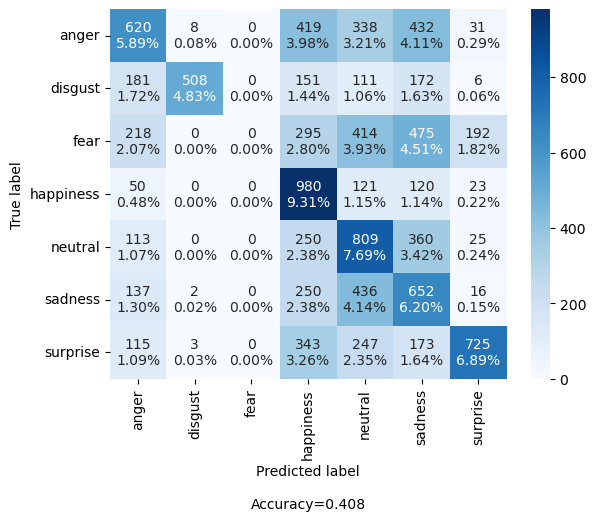

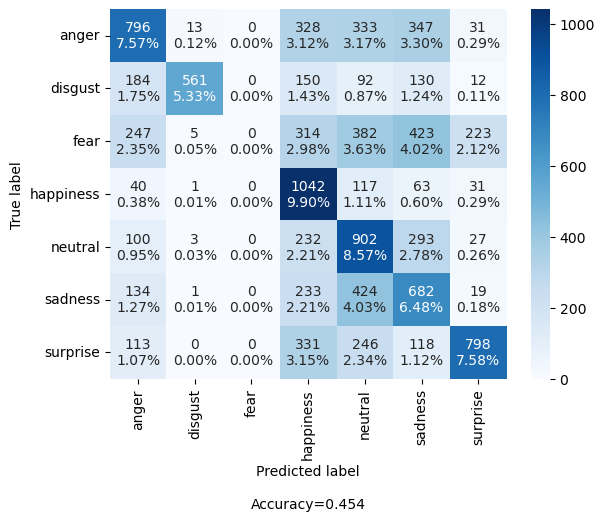

In [18]:
show_test_res(history)
show_test_res(historyBN)

## Save the model

In [19]:
from joblib import dump

def save_model_json(model, name="model_convnet"):
    model_json = model.to_json()
    with open(name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(name + ".h5")
    print("Model saved as JSON file, and weights as .h5 file.")

def save_model(model, name="model_convnet"):
    dump(model, name + ".pkl")
    print("Model saved")

In [25]:
import pickle

def save_variable(x, name="CNN"):
    #file = open(name + '.txt', 'w')
    #pickle.dump(x, file)
    #file.close()
    
    with open(name+".txt", 'w') as f: 
        for key, value in x.items(): 
            f.write('%s:%s\n' % (key, value))
        f.close()
 
#Later, open it with the following lines
#with open('Python.txt', 'rb') as f:
#    dict = pickle.load(f)

In [26]:
#save_model_json(FERmodel, "CNN")
#save_model(FERmodel, "CNN")
save_variable(history, "history_dict_CNN1")

#save_model_json(FERmodel_BN, "CNN_BN")
#save_model(FERmodel_BN, "CNN_BN")
save_variable(historyBN, "history_dict_CNN_BN")

Do the same with a model with batch normalization

In [22]:
"""model0 = create_model()
model0_BN = create_model(True)
compile_model(model0)
compile_model(model0_BN)

h = train_kfold(model0, X_train, y_train, k=2, bs=64, ep=2)
a = h["val_reports"]
a = h["val_cf_matrixes"]
print(a[0])
print(b[0])
#train_kfold(model0_BN, X_train, y_train)
"""

'model0 = create_model()\nmodel0_BN = create_model(True)\ncompile_model(model0)\ncompile_model(model0_BN)\n\nh = train_kfold(model0, X_train, y_train, k=2, bs=64, ep=2)\na = h["val_reports"]\na = h["val_cf_matrixes"]\nprint(a[0])\nprint(b[0])\n#train_kfold(model0_BN, X_train, y_train)\n'